In [2]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



# 魔法函数
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 为 plots 设置默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 更多魔法函数请看下面链接介绍;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# 加载原始CIFAR-10数据.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为健全性检查，我们打印出训练和测试数据的大小.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


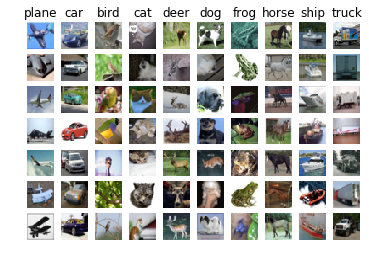

In [4]:
# 将数据集中的一些示例标准化.
# 我们展示了每个课程的一些训练图像示例.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# 在本练习中对数据进行二次采样以更有效地执行代码
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# 将图像数据整形为行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [7]:
from cs231n.classifiers import KNearestNeighbor

# 创建一个kNN分类器实例. 
# 请记住，训练kNN分类器是没有经验的: 
# 分类器仅记住数据并且不进行进一步处理 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [8]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


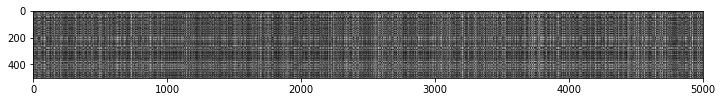

In [19]:
# 我们可以可视化距离矩阵：每一行都是一个测试示例，
# 与训练范例的距离
plt.figure(figsize = (12, 120))
plt.imshow(dists, interpolation='none')
plt.savefig("filename.png")
plt.show()

In [9]:
# 现在实现函数predict_labels并运行下面的代码
# 我们使用k = 1（这是最近的邻居）.
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


### 以下是实训内容，通过设置不同的K值进行训练

In [12]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')
#     robenius norm. In case
# you haven't seen it before, the Frobenius norm of two 

Difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 42.405626 seconds
One loop version took 73.428732 seconds
No loop version took 1.088092 seconds


In [14]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds=np.array_split(X_train,num_folds)
y_train_folds=np.array_split(y_train,num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
for i in k_choices:
    k_to_accuracies[i]=[]
################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for ki in k_choices:
    for fi in range(num_folds):
        #prepare the data
        valindex=fi
        X_traini = np.vstack((X_train_folds[0:fi]+X_train_folds[fi+1:num_folds]))
        y_traini = np.hstack((y_train_folds[0:fi]+ y_train_folds[fi+1:num_folds]))

        X_vali=np.array(X_train_folds[valindex])
        y_vali = np.array(y_train_folds[valindex])
        num_val=len(y_vali)

        #initialize the KNN
        classifier = KNearestNeighbor()
        classifier.train(X_traini,y_traini)

        #calculate the accuracy
        dists = classifier.compute_distances_one_loop(X_vali)
        y_val_pred = classifier.predict_labels(dists, k=ki)
        num_correct = np.sum(y_val_pred == y_vali)
        accuracy = float(num_correct) / num_val
        print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[ki].append(accuracy)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Got 263 / 500 correct => accuracy: 0.263000
Got 257 / 500 correct => accuracy: 0.257000
Got 264 / 500 correct => accuracy: 0.264000
Got 278 / 500 correct => accuracy: 0.278000
Got 266 / 500 correct => accuracy: 0.266000
Got 239 / 500 correct => accuracy: 0.239000
Got 249 / 500 correct => accuracy: 0.249000
Got 240 / 500 correct => accuracy: 0.240000
Got 266 / 500 correct => accuracy: 0.266000
Got 254 / 500 correct => accuracy: 0.254000
Got 248 / 500 correct => accuracy: 0.248000
Got 266 / 500 correct => accuracy: 0.266000
Got 280 / 500 correct => accuracy: 0.280000
Got 292 / 500 correct => accuracy: 0.292000
Got 280 / 500 correct => accuracy: 0.280000
Got 262 / 500 correct => accuracy: 0.262000
Got 282 / 500 correct => accuracy: 0.282000
Got 273 / 500 correct => accuracy: 0.273000
Got 290 / 500 correct => accuracy: 0.290000
Got 273 / 500 correct => accuracy: 0.273000
Got 265 / 500 correct => accuracy: 0.265000
Got 296 / 500 correct => accuracy: 0.296000
Got 276 / 500 correct => accurac

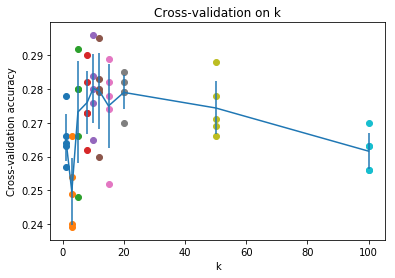

In [15]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [16]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000
